# Import

In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# Misc
import os
import json
import joblib
import warnings
from ipywidgets import IntProgress
from IPython.display import display

# Data management
import numpy as np
import pandas as pd

# Sound treatments
import librosa
import soundfile as sf
from scipy import signal

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import KFold
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

# Class weight
from sklearn.utils.class_weight import compute_class_weight

# Model
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# TRILL
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
assert tf.executing_eagerly()
import tensorflow_hub as hub

# EfficientNetB0
from keras.applications.efficientnet import EfficientNetB0
from keras.applications.efficientnet import preprocess_input

# VGGish
from vggish import vggish_input
from vggish import vggish_params as params
import vggish_keras as vgk

# Meta model
from sklearn.ensemble import RandomForestClassifier

## Metrics
import tensorflow_addons as tfa
from tensorflow_addons.layers.netvlad import NetVLAD
from sklearn.metrics import f1_score

# Plot
import matplotlib.pyplot as plt

# Environment

In [3]:
# Inactivate warnings
warnings.filterwarnings('ignore')

# Allow to display all dataframes columns
pd.set_option("display.max_columns", None)

# Display Tensorlfow version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.config.list_physical_devices('GPU'):
    print('No GPU found. Please ensure you have installed TensorFlow correctly')
    
else:
    print('Default GPU Device: {}'.format(
        tf.config.list_physical_devices('GPU')))

    # Allow memory growth
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

TensorFlow Version: 2.6.0
Default GPU Device: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
#DATA_PATH = '/kaggle/input/birdclef-2022/'
#WORKING_PATH = '/kaggle/working/'
#MODEL_PATH = '/kaggle/input/kernel-efficientnetb0-melspec/'

DATA_PATH = './data/'
WORKING_PATH = './working/stackingz/'
MODEL_PATH = './working/stackingz/'

# Data generator

In [5]:
class DataGenerator_trill(Sequence):
    def __init__(self,
                 _X,
                 batch_size=32,
                 n_channels=1,
                 n_columns=470,
                 n_rows=120,
                 shuffle=True):
        self.batch_size = batch_size
        self.X = _X
        self.n_channels = n_channels
        self.n_columns = n_columns
        self.n_rows = n_rows
        self.shuffle = shuffle
        self.img_indexes = np.arange(len(self.X))
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.img_indexes) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temps = [self.img_indexes[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temps)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.X))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temps):
        X = np.empty((self.batch_size, 80000))
        y = np.empty((self.batch_size, 21), dtype=int)
        for i, ID in enumerate(list_IDs_temps):
            file_path = self.X.iloc[ID]['filename']

            #audio, sr = librosa.load(file_path)
            #feat = extractFeatures(audio, sr)

            feat = data_mem[file_path]

            x_features = feat.tolist()
            label = self.X.iloc[ID]['target']
            X[i] = np.array(x_features)
            y[i] = mlb.transform([label])

        return X, y

In [6]:
class DataGenerator_EfficientNetB0(Sequence):
    def __init__(self,
                 _X,
                 batch_size=32,
                 n_channels=1,
                 n_columns=470,
                 n_rows=120,
                 shuffle=True):
        self.batch_size = batch_size
        self.X = _X
        self.n_channels = n_channels
        self.n_columns = n_columns
        self.n_rows = n_rows
        self.shuffle = shuffle
        self.img_indexes = np.arange(len(self.X))
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.img_indexes) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temps = [self.img_indexes[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temps)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.X))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temps):
        X = np.empty((self.batch_size, self.n_rows, self.n_columns, self.n_channels))
        y = np.empty((self.batch_size, len(mlb.classes_)), dtype=int)
        for i, ID in enumerate(list_IDs_temps):
            file_path = self.X.iloc[ID]['filename']
            
            #audio, sr = librosa.load(file_path)
            #feat = extractFeatures(audio, sr)
            
            feat = data_mem[file_path]
            
            #x_features = feat.tolist()
            label = self.X.iloc[ID]['target']
            #X[i] = np.array(x_features)
            X[i] = feat
            y[i] = mlb.transform([label])
        
        return X, y

In [7]:
class DataGenerator_VGGish(Sequence):
    def __init__(self,
                 _X,
                 batch_size=32,
                 n_channels=1,
                 n_columns=470,
                 n_rows=120,
                 shuffle=True):
        self.batch_size = batch_size
        self.X = _X
        self.n_channels = n_channels
        self.n_columns = n_columns
        self.n_rows = n_rows
        self.shuffle = shuffle
        self.img_indexes = np.arange(len(self.X))
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.img_indexes) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temps = [self.img_indexes[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temps)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.X))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temps):
        X = np.empty((self.batch_size, self.n_rows, self.n_columns, self.n_channels))
        y = np.empty((self.batch_size, len(mlb.classes_)), dtype=int)
        for i, ID in enumerate(list_IDs_temps):
            file_path = self.X.iloc[ID]['filename']
            
            #audio, sr = librosa.load(file_path)
            #feat = extractFeatures(audio, sr)
            
            feat = data_mem[file_path]
            
            x_features = feat.tolist()
            label = self.X.iloc[ID]['target']
            X[i] = np.array(x_features)
            y[i] = mlb.transform([label])
        X = X.reshape(X.shape[0], self.n_rows, self.n_columns, self.n_channels)
        
        return X, y

In [8]:
data_mem = {}

def LoadRAM():
    # Load extracted features into RAM
    data_mem.clear()

    # Instantiate the progress bar
    max_count = data_df.shape[0]
    f = IntProgress(min=0, max=max_count)
    # Display the progress bar
    display(f)

    temp = {}

    for index, row in data_df.iterrows():
        # Increment the progress bar
        f.value += 1

        # Get file path
        file_path = row['filename']
        # Load audio file
        audio, sr = librosa.load(file_path)
        # Extracxt features
        feat = extractFeatures(audio, sr)
        
        # Store features into the dedicated dictionary
        temp[row['filename']] = feat
        
    return temp

# Data load

In [9]:
# Load meta data
train_meta = pd.read_csv(DATA_PATH + 'train_metadata.csv')

# Load scored birds
with open(DATA_PATH + 'scored_birds.json') as sbfile:
    scored_birds = json.load(sbfile)
    
# Focus on 21 scored classes
labels = list(train_meta[train_meta['primary_label'].isin(scored_birds)]['primary_label'].unique())
labels

['akiapo',
 'aniani',
 'apapan',
 'barpet',
 'crehon',
 'elepai',
 'ercfra',
 'hawama',
 'hawcre',
 'hawgoo',
 'hawhaw',
 'hawpet1',
 'houfin',
 'iiwi',
 'jabwar',
 'maupar',
 'omao',
 'puaioh',
 'skylar',
 'warwhe1',
 'yefcan']

In [10]:
data_df = pd.read_pickle(WORKING_PATH + 'data_augmented_df.pkl')
data_df

,primary_label,secondary_labels,original_filename,filename,target
0,akiapo,"['apapan', 'hawama', 'iiwi']",akiapo/XC122399.ogg,./working/final/each5s/split_1_akiapo_XC122399...,"(akiapo, apapan, hawama, iiwi)"
1,akiapo,"['apapan', 'hawama', 'iiwi']",akiapo/XC122399.ogg,./working/final/each5s/split_1_akiapo_XC122399...,"(akiapo, apapan, hawama, iiwi)"
2,akiapo,"['apapan', 'hawama', 'iiwi']",akiapo/XC122399.ogg,./working/final/each5s/split_1_akiapo_XC122399...,"(akiapo, apapan, hawama, iiwi)"
3,akiapo,"['apapan', 'hawama', 'iiwi']",akiapo/XC122399.ogg,./working/final/each5s/split_1_akiapo_XC122399...,"(akiapo, apapan, hawama, iiwi)"
4,akiapo,"['apapan', 'hawama', 'iiwi']",akiapo/XC122399.ogg,./working/final/each5s/split_2_akiapo_XC122399...,"(akiapo, apapan, hawama, iiwi)"
...,...,...,...,...,...
56315,yefcan,[],yefcan/XC667142.ogg,./working/final/each5s/split_6_yefcan_XC667142...,"(yefcan,)"
56316,yefcan,[],yefcan/XC667142.ogg,./working/final/each5s/split_7_yefcan_XC667142...,"(yefcan,)"
56317,yefcan,[],yefcan/XC667142.ogg,./working/final/each5s/split_7_yefcan_XC667142...,"(yefcan,)"
56318,yefcan,[],yefcan/XC667142.ogg,./working/final/each5s/split_7_yefcan_XC667142...,"(yefcan,)"


In [11]:
# Fit a MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit(data_df['target'].values.tolist())

MultiLabelBinarizer()

In [12]:
mlb.classes_

array(['akiapo', 'aniani', 'apapan', 'barpet', 'crehon', 'elepai',
       'ercfra', 'hawama', 'hawcre', 'hawgoo', 'hawhaw', 'hawpet1',
       'houfin', 'iiwi', 'jabwar', 'maupar', 'omao', 'puaioh', 'skylar',
       'warwhe1', 'yefcan'], dtype=object)

# Classes weight management function

In [13]:
def class_weight(generator, mu=0.15):
    weights = {}

    labels_dict = {}
    count_class = 0
    for item in mlb.classes_:
        labels_dict[count_class] = 0

        for index, row in generator.X.iterrows():
            if item in row['target']:
                labels_dict[count_class] += 1
                
        count_class += 1

    total = sum(labels_dict.values())
    keys = labels_dict.keys()

    for i in sorted(keys):
        score = np.log(mu*total/float(labels_dict[i]))
        weights[i] = score if score > 1 else 1

    return weights

# Ensemble

In [14]:
# Callbacks
es_callback = EarlyStopping(monitor='val_loss',
                            mode='min',
                            patience=5,
                            verbose=1,
                            restore_best_weights=True
                            )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.8,
                              mode='min',
                              patience=1,
                              verbose=1,
                              min_delta=0.0001,
                              cooldown=1,
                              min_lr=0.00001)

In [15]:
# Split
X_train, X_valid, _, _ = train_test_split(
    data_df, data_df['target'], test_size=0.2, random_state=42)

## Trill-distilled/3

### Preprocessing

In [75]:
# Sound noise reduction
def f_high(y,sr):
    b,a = signal.butter(10, 1000/(sr/2), btype='highpass')
    yf = signal.lfilter(b,a,y)
    return yf

In [76]:
def extractFeatures(y, sr):
    # Sound noise reduction
    y = f_high(y, sr)
    # Resample
    y = librosa.resample(y, sr, 16000, res_type='fft')

    return y

In [77]:
params = dict(
    batch_size=32,
    n_rows=224,
    n_columns=216,
    n_channels=3,
)
params_train = dict(
    shuffle=False,
    **params
)
params_valid = dict(
    shuffle=False,
    **params
)

In [78]:
# Load data in RAM to speed up training process
data_mem = LoadRAM()

IntProgress(value=0, max=56320)

### Model

In [29]:
def get_keras_model(num_classes, input_length, use_batchnorm=True, l2=1e-5,
                    num_clusters=None, trainable=True, pooling='avg', hidden=0):
    """Make a model."""
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.Input((input_length,)))
    
    # 'https://tfhub.dev/google/nonsemantic-speech-benchmark/trill-distilled/3'
    trill_layer = hub.KerasLayer(
        handle=MODEL_PATH + 'trill/',
        trainable=trainable,
        arguments={'sample_rate': int(16000)},
        output_key='embedding',
        output_shape=[None, 2048]
    )
    
    model.add(trill_layer)
    
    if num_clusters and num_clusters > 0:
        model.add(NetVLAD(num_clusters=num_clusters))
        if use_batchnorm:
            model.add(tf.keras.layers.BatchNormalization())
    else:
        if pooling == 'avg':
            # Average pooling
            model.add(tf.keras.layers.GlobalAveragePooling1D())  
        else:
            model.add(tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=1)))
       
    # Hidden layer
    if hidden != 0:
        model.add(tf.keras.layers.Dense(
            hidden, 
            activation='relu'))
    
    # Fully connected
    model.add(tf.keras.layers.Dense(
        num_classes, 
        activation='sigmoid',
        kernel_regularizer=tf.keras.regularizers.l2(l=l2)))

    return model

In [66]:
def create_cnn(num_clusters, use_batchnorm, pooling, hidden, fine_tune_at, model_path):
    if fine_tune_at == None:
        print('fine_tune_at == None')
        model = get_keras_model(len(labels), 
                                80000, 
                                use_batchnorm=use_batchnorm, 
                                l2=1e-5,
                                num_clusters=num_clusters, 
                                trainable=False,
                                pooling=pooling,
                                hidden=hidden
                               )

    else:
        print('model.load_weights')
        model = get_keras_model(len(labels), 
                                80000, 
                                use_batchnorm=use_batchnorm, 
                                l2=1e-5,
                                num_clusters=num_clusters, 
                                trainable=True,
                                pooling=pooling,
                                hidden=hidden
                               )

        # Load existing weights
        model.load_weights(model_path)

    print('')
    model.summary()
    print('')
    
    return model

In [31]:
# collect out of sample predictions
trill_yhat = {}
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

for train_ix, test_ix in kfold.split(X_train):
    # get data
    train_X, test_X = X_train.iloc[train_ix], X_train.iloc[test_ix]
    
    # Instanciate data generators
    train_generator = DataGenerator_trill(train_X, **params_train)
    test_generator = DataGenerator_trill(test_X, **params_train)
    
    # Class weights
    print('Class weights...')
    class_weights = class_weight(generator=train_generator, mu=0.675)
    
    # Create TRILL model
    print('Create model...')
    Trill = create_cnn(num_clusters=8, use_batchnorm=True,
                       pooling=None, hidden=256,
                       fine_tune_at=None, model_path=None)
    Trill.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=[tfa.metrics.F1Score(name='f1macro', num_classes=len(labels), average='macro')])
    
    print('fit...')
    Trill.fit(
        train_generator,
        validation_data=test_generator,
        epochs=50,
        callbacks=[es_callback, reduce_lr],
        verbose=1,
        class_weight=class_weights
    )

    # Predict & store
    print('predict_on_batch...')
    for index, row in test_generator.X.iterrows():
        pred = Trill.predict_on_batch(data_mem[row['filename']].reshape(1, -1))
        trill_yhat[index] = pred[0]

Class weights...
Create model...
fine_tune_at == None

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, None, 2048)        51964864  
_________________________________________________________________
net_vlad_2 (NetVLAD)         (None, 16384)             32776     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16384)             65536     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               4194560   
_________________________________________________________________
dense_3 (Dense)              (None, 21)                5397      
Total params: 56,263,133
Trainable params: 4,265,501
Non-trainable params: 51,997,632
_________________________________________________________________

fit...
Epoch 1/50
938/938 [=================

938/938 [==============================] - 212s 226ms/step - loss: 0.0161 - f1macro: 0.7544 - val_loss: 0.0304 - val_f1macro: 0.7405
Epoch 11/50
938/938 [==============================] - 228s 243ms/step - loss: 0.0149 - f1macro: 0.7486 - val_loss: 0.0319 - val_f1macro: 0.7119

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0005120000336319208.
Epoch 12/50
938/938 [==============================] - 214s 228ms/step - loss: 0.0125 - f1macro: 0.7521 - val_loss: 0.0325 - val_f1macro: 0.7401

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00040960004553198815.
Epoch 13/50
938/938 [==============================] - 228s 243ms/step - loss: 0.0109 - f1macro: 0.7389 - val_loss: 0.0292 - val_f1macro: 0.7242
Epoch 14/50
938/938 [==============================] - 221s 236ms/step - loss: 0.0105 - f1macro: 0.7443 - val_loss: 0.0306 - val_f1macro: 0.7209 - loss: 0.0106 - f1macro: 0.74 -

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.00032768002711236477.
Epoch 15/

### Save model

In [32]:
Trill.save_weights(WORKING_PATH + 'trill.h5')

In [33]:
joblib.dump(trill_yhat, WORKING_PATH + 'trill_yhat.jl')

['./working/stackingz/trill_yhat.jl']

## EfficientNetB0

### Preprocessing

In [85]:
class conf:
    # Preprocessing settings
    sampling_rate = 44100
    n_mels = 224
    hop_length = 494
    n_fft = n_mels * 10
    fmin = 20
    fmax = 16000
    
    # Model parameters
    num_rows = 224
    num_columns = 224
    num_channels = 3

In [86]:
def audio_to_melspectrogram(audio):
    spectrogram = librosa.feature.melspectrogram(audio,
                                                 sr=conf.sampling_rate,
                                                 n_mels=conf.n_mels,
                                                 hop_length=conf.hop_length,
                                                 n_fft=conf.n_fft,
                                                 fmin=conf.fmin,
                                                 fmax=conf.fmax)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram

In [87]:
def mono_to_color(X, eps=1e-6, mean=None, std=None):
    """
    Converts a one channel array to a 3 channel one in [0, 255]
    Arguments:
        X {numpy array [H x W]} -- 2D array to convert
    Keyword Arguments:
        eps {float} -- To avoid dividing by 0 (default: {1e-6})
        mean {None or np array} -- Mean for normalization (default: {None})
        std {None or np array} -- Std for normalization (default: {None})
    Returns:
        numpy array [3 x H x W] -- RGB numpy array
    """
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)

    # Normalize to [0, 255]
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V

In [88]:
def extractFeatures(y, sr):
    # Extract features
    feat = audio_to_melspectrogram(y)
    feat = mono_to_color(feat)
    feat = feat.astype(np.uint8)
    
    # EfficientNet preprocess
    feat = preprocess_input(feat)
    
    X = np.empty((1, conf.num_rows, conf.num_columns, conf.num_channels))
    x_features = feat.tolist()
    X[0] = np.array(x_features)
        
    return X

In [89]:
params = dict(
    batch_size=16,
    n_rows=conf.num_rows,
    n_columns=conf.num_columns,
    n_channels=conf.num_channels,
)
params_train = dict(
    shuffle=False,
    **params
)
params_valid = dict(
    shuffle=False,
    **params
)

In [90]:
# Load data in RAM to speed up training process
data_mem.clear()
data_mem = LoadRAM()

IntProgress(value=0, max=56320)

### Model

In [91]:
def create_cnn(fine_tune_at=None,
               model_path=None
               ):

    # Instanciate model
    from keras.applications.efficientnet import EfficientNetB0
    base_model = EfficientNetB0(include_top=False, input_shape=(
        conf.num_rows, conf.num_columns, conf.num_channels), weights='imagenet', pooling='avg')
    # Hidden neurons' number (input + output neurons) * 2/3 - 21
    dense = Dense(142, activation='relu')(
        base_model.output)
    outputs = Dense(len(mlb.classes_), activation='sigmoid')(dense)

    base_model.trainable = False

    if fine_tune_at == None:
        model = Model(inputs=base_model.input, outputs=outputs)

    else:
        model = Model(inputs=base_model.input, outputs=outputs)

        # Load existing weights
        model.load_weights(model_path)

        # Unfreeze model layers
        model.trainable = True

        # Freeze all the layers before the `fine_tune_at` layer
        for layer in model.layers[:fine_tune_at]:
            layer.trainable = False

    return model

In [41]:
# collect out of sample predictions
EfficientNetB0_yhat = {}
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

for train_ix, test_ix in kfold.split(X_train):
    # get data
    train_X, test_X = X_train.iloc[train_ix], X_train.iloc[test_ix]

    # Instanciate data generators
    train_generator = DataGenerator_EfficientNetB0(train_X, **params_train)
    test_generator = DataGenerator_EfficientNetB0(test_X, **params_train)
    
    # Class weights
    print('Class weights...')
    class_weights = class_weight(generator=train_generator, mu=0.675)

    # Create EfficientNetB0 model
    print('Create model...')
    EfficientNetB0 = create_cnn()
    EfficientNetB0.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss='binary_crossentropy',
                     metrics=[tfa.metrics.F1Score(name='f1macro', num_classes=len(labels), average='macro')])

    print('fit...')
    EfficientNetB0.fit(
        train_generator,
        validation_data=test_generator,
        epochs=50,
        callbacks=[es_callback, reduce_lr],
        verbose=1,
        class_weight=class_weights
    )

    # Predict & store
    # Instantiate the progress bar
    max_count = test_generator.X.shape[0]
    f = IntProgress(min=0, max=max_count)
    # Display the progress bar
    display(f)

    print('predict_on_batch...')
    for index, row in test_generator.X.iterrows():
        # Increment the progress bar
        f.value += 1
        # Format data
        X = np.empty((1, conf.num_rows, conf.num_columns, conf.num_channels))
        X[0] = np.array(data_mem[row['filename']])
        # Predict
        pred = EfficientNetB0.predict_on_batch(X)
        # Store prediction
        EfficientNetB0_yhat[index] = pred[0]

Class weights...
Create model...
fit...
Epoch 1/50
1877/1877 [==============================] - 225s 117ms/step - loss: 0.2373 - f1macro: 0.2479 - val_loss: 0.0930 - val_f1macro: 0.3042
Epoch 2/50
1877/1877 [==============================] - 236s 126ms/step - loss: 0.1861 - f1macro: 0.3610 - val_loss: 0.0817 - val_f1macro: 0.4327
Epoch 3/50
1877/1877 [==============================] - 281s 150ms/step - loss: 0.1681 - f1macro: 0.4258 - val_loss: 0.0781 - val_f1macro: 0.4110
Epoch 4/50
1877/1877 [==============================] - 283s 151ms/step - loss: 0.1559 - f1macro: 0.4595 - val_loss: 0.0786 - val_f1macro: 0.4701

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
Epoch 5/50
1877/1877 [==============================] - 278s 148ms/step - loss: 0.1458 - f1macro: 0.4820 - val_loss: 0.0679 - val_f1macro: 0.4766
Epoch 6/50
1877/1877 [==============================] - 288s 153ms/step - loss: 0.1378 - f1macro: 0.5007 - val_loss: 0.0685 - val_f1macro: 0.4712

Epo

IntProgress(value=0, max=15019)

predict_on_batch...
Class weights...
Create model...
fit...
Epoch 1/50
1877/1877 [==============================] - 209s 104ms/step - loss: 0.2330 - f1macro: 0.2565 - val_loss: 0.0993 - val_f1macro: 0.3210
Epoch 2/50
1877/1877 [==============================] - 204s 108ms/step - loss: 0.1842 - f1macro: 0.3700 - val_loss: 0.0830 - val_f1macro: 0.4304
Epoch 3/50
1877/1877 [==============================] - 229s 122ms/step - loss: 0.1658 - f1macro: 0.4136 - val_loss: 0.0790 - val_f1macro: 0.4085
Epoch 4/50
1877/1877 [==============================] - 208s 111ms/step - loss: 0.1540 - f1macro: 0.4645 - val_loss: 0.0803 - val_f1macro: 0.4589

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
Epoch 5/50
1877/1877 [==============================] - 218s 116ms/step - loss: 0.1415 - f1macro: 0.4960 - val_loss: 0.0731 - val_f1macro: 0.4679
Epoch 6/50
1877/1877 [==============================] - 224s 119ms/step - loss: 0.1356 - f1macro: 0.5075 - val_loss: 0.0664 - val_

IntProgress(value=0, max=15019)

predict_on_batch...
Class weights...
Create model...
fit...
Epoch 1/50
1877/1877 [==============================] - 200s 104ms/step - loss: 0.2375 - f1macro: 0.2476 - val_loss: 0.0871 - val_f1macro: 0.3616
Epoch 2/50
1877/1877 [==============================] - 216s 115ms/step - loss: 0.1847 - f1macro: 0.3856 - val_loss: 0.0820 - val_f1macro: 0.3841
Epoch 3/50
1877/1877 [==============================] - 203s 108ms/step - loss: 0.1662 - f1macro: 0.4391 - val_loss: 0.0745 - val_f1macro: 0.4729
Epoch 4/50
1877/1877 [==============================] - 206s 110ms/step - loss: 0.1531 - f1macro: 0.4732 - val_loss: 0.0715 - val_f1macro: 0.4797
Epoch 5/50
1877/1877 [==============================] - 211s 112ms/step - loss: 0.1434 - f1macro: 0.4902 - val_loss: 0.0700 - val_f1macro: 0.51571436 - f1macro: 
Epoch 6/50
1877/1877 [==============================] - 215s 115ms/step - loss: 0.1358 - f1macro: 0.4958 - val_loss: 0.0674 - val_f1macro: 0.4774
Epoch 7/50
1877/1877 [==========================

IntProgress(value=0, max=15018)

predict_on_batch...


### Save model

In [42]:
EfficientNetB0.save_weights(WORKING_PATH + 'EfficientNetB0.h5')

In [43]:
joblib.dump(EfficientNetB0_yhat, WORKING_PATH + 'EfficientNetB0_yhat.jl')

['./working/stackingz/EfficientNetB0_yhat.jl']

## VGGish

### Preprocessing

In [98]:
# Sound noise reduction
def f_high(y,sr):
    b,a = signal.butter(10, 2000/(sr/2), btype='highpass')
    yf = signal.lfilter(b,a,y)
    return yf

In [99]:
def waveform_to_examples(data, sample_rate):
    # Convert to mono.
    if len(data.shape) > 1:
        data = np.mean(data, axis=1)
    # Resample to the rate assumed by VGGish.
    if sample_rate != 16000:
        #data = resampy.resample(data, sample_rate, 16000)
        data = librosa.resample(data, sample_rate, 16000, res_type='fft')

    # Compute log mel spectrogram features.
    log_mel = log_mel_spectrogram(
        data,
        audio_sample_rate=16000,
        log_offset=0.01,
        window_length_secs=0.025,
        hop_length_secs=0.010,
        num_mel_bins=64,
        lower_edge_hertz=1500,
        upper_edge_hertz=8000)

    # Frame features into examples.
    features_sample_rate = 1.0 / 0.010
    example_window_length = int(round(0.96 * features_sample_rate))
    example_hop_length = int(round(0.96 * features_sample_rate))
    log_mel_examples = frame(
        log_mel,
        window_length=example_window_length,
        hop_length=example_hop_length)
    return log_mel_examples

In [100]:
def log_mel_spectrogram(data,
                        audio_sample_rate=8000,
                        log_offset=0.0,
                        window_length_secs=0.025,
                        hop_length_secs=0.010,
                        **kwargs):
    window_length_samples = int(round(audio_sample_rate * window_length_secs))
    hop_length_samples = int(round(audio_sample_rate * hop_length_secs))
    fft_length = 2 ** int(np.ceil(np.log(window_length_samples) / np.log(2.0)))
    spectrogram = stft_magnitude(
        data,
        fft_length=fft_length,
        hop_length=hop_length_samples,
        window_length=window_length_samples)
    mel_spectrogram = np.dot(spectrogram, spectrogram_to_mel_matrix(
        num_spectrogram_bins=spectrogram.shape[1],
        audio_sample_rate=audio_sample_rate, **kwargs))
    return np.log(mel_spectrogram + log_offset)

In [101]:
def frame(data, window_length, hop_length):
    num_samples = data.shape[0]
    num_frames = 1 + int(np.floor((num_samples - window_length) / hop_length))
    shape = (num_frames, window_length) + data.shape[1:]
    strides = (data.strides[0] * hop_length,) + data.strides
    return np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)

In [102]:
def stft_magnitude(signal, fft_length,
                   hop_length=None,
                   window_length=None):
    frames = frame(signal, window_length, hop_length)
    # Apply frame window to each frame. We use a periodic Hann (cosine of period
    # window_length) instead of the symmetric Hann of np.hanning (period
    # window_length-1).
    window = periodic_hann(window_length)
    windowed_frames = frames * window
    return np.abs(np.fft.rfft(windowed_frames, int(fft_length)))

In [103]:
def periodic_hann(window_length):
    return 0.5 - (0.5 * np.cos(2 * np.pi / window_length *
                               np.arange(window_length)))

In [104]:
def spectrogram_to_mel_matrix(num_mel_bins=20,
                              num_spectrogram_bins=129,
                              audio_sample_rate=8000,
                              lower_edge_hertz=125.0,
                              upper_edge_hertz=3800.0):
    nyquist_hertz = audio_sample_rate / 2.
    if lower_edge_hertz < 0.0:
        raise ValueError("lower_edge_hertz %.1f must be >= 0" %
                         lower_edge_hertz)
    if lower_edge_hertz >= upper_edge_hertz:
        raise ValueError("lower_edge_hertz %.1f >= upper_edge_hertz %.1f" %
                         (lower_edge_hertz, upper_edge_hertz))
    if upper_edge_hertz > nyquist_hertz:
        raise ValueError("upper_edge_hertz %.1f is greater than Nyquist %.1f" %
                         (upper_edge_hertz, nyquist_hertz))
    spectrogram_bins_hertz = np.linspace(
        0.0, nyquist_hertz, num_spectrogram_bins)
    spectrogram_bins_mel = hertz_to_mel(spectrogram_bins_hertz)
    # The i'th mel band (starting from i=1) has center frequency
    # band_edges_mel[i], lower edge band_edges_mel[i-1], and higher edge
    # band_edges_mel[i+1].  Thus, we need num_mel_bins + 2 values in
    # the band_edges_mel arrays.
    band_edges_mel = np.linspace(hertz_to_mel(lower_edge_hertz),
                                 hertz_to_mel(upper_edge_hertz), num_mel_bins + 2)
    # Matrix to post-multiply feature arrays whose rows are num_spectrogram_bins
    # of spectrogram values.
    mel_weights_matrix = np.empty((num_spectrogram_bins, num_mel_bins))
    for i in range(num_mel_bins):
        lower_edge_mel, center_mel, upper_edge_mel = band_edges_mel[i:i + 3]
        # Calculate lower and upper slopes for every spectrogram bin.
        # Line segments are linear in the *mel* domain, not hertz.
        lower_slope = ((spectrogram_bins_mel - lower_edge_mel) /
                       (center_mel - lower_edge_mel))
        upper_slope = ((upper_edge_mel - spectrogram_bins_mel) /
                       (upper_edge_mel - center_mel))
        # .. then intersect them with each other and zero.
        mel_weights_matrix[:, i] = np.maximum(0.0, np.minimum(lower_slope,
                                                              upper_slope))
    # HTK excludes the spectrogram DC bin; make sure it always gets a zero
    # coefficient.
    mel_weights_matrix[0, :] = 0.0
    return mel_weights_matrix

In [105]:
def hertz_to_mel(frequencies_hertz):
    return 1127.0 * np.log(
        1.0 + (frequencies_hertz / 700.0))

In [106]:
def extractFeatures(y, sr):
    # Sound noise reduction
    y = f_high(y, sr)
    
    feat = waveform_to_examples(y, sr)
        
    return feat

In [107]:
params = dict(
    batch_size=32,
    n_rows=5,
    n_columns=96,
    n_channels=64,
)
params_train = dict(
    shuffle=True,
    **params
)
params_valid = dict(
    shuffle=False,
    **params
)

In [108]:
# Load data in RAM to speed up training process
data_mem.clear()
data_mem = LoadRAM()

IntProgress(value=0, max=56320)

### Model

In [109]:
def create_cnn(fine_tune_at=None,
               model_path=None
               ):

    # Instanciate model
    base_model, _, _ = vgk.get_embedding_model(hop_duration=0.25)   
    dense = Dense(128, activation='relu')(base_model.output)
    outputs = Dense(len(mlb.classes_), activation='sigmoid')(dense)
      
    base_model.trainable = True
    
    if fine_tune_at == None:     
        model = Model(inputs=base_model.input, outputs=outputs)

    else:
        model = Model(inputs=base_model.input, outputs=outputs)

        # Load existing weights
        model.load_weights(model_path)

        # Unfreeze model layers
        model.trainable = True

        # Freeze all the layers before the `fine_tune_at` layer
        for layer in model.layers[:fine_tune_at]:
            layer.trainable = False

    return model

In [56]:
# collect out of sample predictions
VGGish_yhat = {}
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

for train_ix, test_ix in kfold.split(X_train):
    # get data
    train_X, test_X = X_train.iloc[train_ix], X_train.iloc[test_ix]

    # Instanciate data generators
    train_generator = DataGenerator_VGGish(train_X, **params_train)
    test_generator = DataGenerator_VGGish(test_X, **params_train)

    # Class weights
    print('Class weights...')
    class_weights = class_weight(generator=train_generator, mu=0.675)

    # Create VGGish model
    print('Create model...')
    VGGish = create_cnn()
    VGGish.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=[tfa.metrics.F1Score(name='f1macro', num_classes=len(labels), average='macro')])

    print('fit...')
    VGGish.fit(
        train_generator,
        validation_data=test_generator,
        epochs=50,
        callbacks=[es_callback, reduce_lr],
        verbose=1,
        class_weight=class_weights
    )

    # Predict & store
    # Instantiate the progress bar
    max_count = test_generator.X.shape[0]
    f = IntProgress(min=0, max=max_count)
    # Display the progress bar
    display(f)

    print('predict_on_batch...')
    for index, row in test_generator.X.iterrows():
        # Increment the progress bar
        f.value += 1
        # Format data
        X = np.empty((1, 5, 96, 64))
        X[0] = np.array(data_mem[row['filename']])
        X = X.reshape(1, 480, 64, 1)
        # Predict
        pred = VGGish.predict_on_batch(X)
        # Store prediction
        VGGish_yhat[index] = pred[0]

Class weights...
Create model...
fit...
Epoch 1/50
938/938 [==============================] - 167s 174ms/step - loss: 0.3408 - f1macro: 0.0641 - val_loss: 0.1426 - val_f1macro: 0.1017cro: - ETA: 6s - loss: 0.3430 - f1macro:  - ETA: 1s - loss: 0.3410 - f1mac
Epoch 2/50
938/938 [==============================] - 145s 155ms/step - loss: 0.2743 - f1macro: 0.1453 - val_loss: 0.1314 - val_f1macro: 0.1629
Epoch 3/50
938/938 [==============================] - 141s 150ms/step - loss: 0.2430 - f1macro: 0.1873 - val_loss: 0.1279 - val_f1macro: 0.1814
Epoch 4/50
938/938 [==============================] - 141s 150ms/step - loss: 0.2208 - f1macro: 0.2403 - val_loss: 0.1113 - val_f1macro: 0.2354
Epoch 5/50
938/938 [==============================] - 142s 151ms/step - loss: 0.2012 - f1macro: 0.2932 - val_loss: 0.0968 - val_f1macro: 0.2830
Epoch 6/50
938/938 [==============================] - 141s 151ms/step - loss: 0.1851 - f1macro: 0.3366 - val_loss: 0.1054 - val_f1macro: 0.3503

Epoch 00006: ReduceLR

IntProgress(value=0, max=15019)

predict_on_batch...
Class weights...
Create model...
fit...
Epoch 1/50
938/938 [==============================] - 139s 148ms/step - loss: 0.3427 - f1macro: 0.0532 - val_loss: 0.1544 - val_f1macro: 0.0671
Epoch 2/50
938/938 [==============================] - 138s 147ms/step - loss: 0.2744 - f1macro: 0.1462 - val_loss: 0.1292 - val_f1macro: 0.1523
Epoch 3/50
938/938 [==============================] - 139s 148ms/step - loss: 0.2381 - f1macro: 0.1841 - val_loss: 0.1222 - val_f1macro: 0.2074
Epoch 4/50
938/938 [==============================] - 138s 148ms/step - loss: 0.2159 - f1macro: 0.2505 - val_loss: 0.1041 - val_f1macro: 0.2753
Epoch 5/50
938/938 [==============================] - 141s 151ms/step - loss: 0.1959 - f1macro: 0.3088 - val_loss: 0.1037 - val_f1macro: 0.2969
Epoch 6/50
938/938 [==============================] - 142s 152ms/step - loss: 0.1790 - f1macro: 0.3345 - val_loss: 0.0946 - val_f1macro: 0.3329
Epoch 7/50
938/938 [==============================] - 141s 151ms/step - loss

IntProgress(value=0, max=15019)

predict_on_batch...
Class weights...
Create model...
fit...
Epoch 1/50
938/938 [==============================] - 139s 148ms/step - loss: 0.3456 - f1macro: 0.0609 - val_loss: 0.1612 - val_f1macro: 0.0659
Epoch 2/50
938/938 [==============================] - 138s 147ms/step - loss: 0.2824 - f1macro: 0.1445 - val_loss: 0.1262 - val_f1macro: 0.1773
Epoch 3/50
938/938 [==============================] - 138s 147ms/step - loss: 0.2433 - f1macro: 0.2028 - val_loss: 0.1090 - val_f1macro: 0.2057
Epoch 4/50
938/938 [==============================] - 140s 149ms/step - loss: 0.2184 - f1macro: 0.2423 - val_loss: 0.1035 - val_f1macro: 0.2397
Epoch 5/50
938/938 [==============================] - 139s 149ms/step - loss: 0.1985 - f1macro: 0.2958 - val_loss: 0.0951 - val_f1macro: 0.2879
Epoch 6/50
938/938 [==============================] - 140s 149ms/step - loss: 0.1804 - f1macro: 0.3305 - val_loss: 0.0882 - val_f1macro: 0.3322
Epoch 7/50
938/938 [==============================] - 140s 149ms/step - loss

IntProgress(value=0, max=15018)

predict_on_batch...


### Save model

In [57]:
VGGish.save_weights(WORKING_PATH + 'VGGish.h5')

In [58]:
joblib.dump(VGGish_yhat, WORKING_PATH + 'VGGish_yhat.jl')

['./working/stackingz/VGGish_yhat.jl']

## Meta model

In [59]:
# create a meta dataset
def create_meta_dataset(data_x, yhat1, yhat2, yhat3):
    # convert to dataframes
    df_new1 = pd.DataFrame.from_dict(yhat1, orient='index', columns=['tr1', 'tr2', 'tr3', 'tr4', 'tr5',
                                                                     'tr6', 'tr7', 'tr8', 'tr9', 'tr10',
                                                                     'tr11', 'tr12', 'tr13', 'tr14', 'tr15',
                                                                     'tr16', 'tr17', 'tr18', 'tr19', 'tr20',
                                                                     'tr21'])
    
    df_new2 = pd.DataFrame.from_dict(yhat2, orient='index', columns=['en1', 'en2', 'en3', 'en4', 'en5',
                                                                     'en6', 'en7', 'en8', 'en9', 'en10',
                                                                     'en11', 'en12', 'en13', 'en14', 'en15',
                                                                     'en16', 'en17', 'en18', 'en19', 'en20',
                                                                     'en21'])
    
    df_new3 = pd.DataFrame.from_dict(yhat3, orient='index', columns=['vg1', 'vg2', 'vg3', 'vg4', 'vg5',
                                                                     'vg6', 'vg7', 'vg8', 'vg9', 'vg10',
                                                                     'vg11', 'vg12', 'vg13', 'vg14', 'vg15',
                                                                     'vg16', 'vg17', 'vg18', 'vg19', 'vg20',
                                                                     'vg21'])
    # create a meta dataset
    X = pd.concat([data_x, df_new1, df_new2, df_new3], axis=1, verify_integrity=True)
    y = mlb.transform(X['target'])

    X = X.drop(['primary_label', 'secondary_labels',
                'original_filename', 'filename', 'target'], axis=1)

    return X, y

In [60]:
# Reload yhats
trill_yhat = joblib.load(WORKING_PATH + 'trill_yhat.jl')
EfficientNetB0_yhat = joblib.load(WORKING_PATH + 'EfficientNetB0_yhat.jl')
VGGish_yhat = joblib.load(WORKING_PATH + 'VGGish_yhat.jl')

In [61]:
# construct meta dataset
meta_X_train, meta_y_train = create_meta_dataset(X_train, trill_yhat, EfficientNetB0_yhat, VGGish_yhat)

In [62]:
# construct meta classifier
meta_model = RandomForestClassifier()
meta_model.fit(meta_X_train, meta_y_train)

RandomForestClassifier()

In [63]:
# Save model
joblib.dump(meta_model, WORKING_PATH + 'meta_model.jl')

['./working/stackingz/meta_model.jl']

## Evaluate

### Sub models on hold out dataset

#### Trill

In [79]:
valid_generator_trill = DataGenerator_trill(X_valid, **params_train)

In [80]:
Trill = create_cnn(num_clusters=8, use_batchnorm=True,
                   pooling=None, hidden=256,
                   fine_tune_at=None, model_path=None)
Trill.load_weights(WORKING_PATH + 'trill.h5')
Trill.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=[tfa.metrics.F1Score(name='f1macro', num_classes=len(labels), average='macro')])

fine_tune_at == None

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_7 (KerasLayer)   (None, None, 2048)        51964864  
_________________________________________________________________
net_vlad_6 (NetVLAD)         (None, 16384)             32776     
_________________________________________________________________
batch_normalization_5 (Batch (None, 16384)             65536     
_________________________________________________________________
dense_22 (Dense)             (None, 256)               4194560   
_________________________________________________________________
dense_23 (Dense)             (None, 21)                5397      
Total params: 56,263,133
Trainable params: 4,265,501
Non-trainable params: 51,997,632
_________________________________________________________________



In [81]:
pred_trill = Trill.evaluate_generator(valid_generator_trill)
pred_trill

[0.029031455516815186, 0.6876097321510315]

In [82]:
meta_pred_trill = {}

for index, row in valid_generator_trill.X.iterrows():
    pred = Trill.predict_on_batch(data_mem[row['filename']].reshape(1, -1))
    meta_pred_trill[index] = pred[0]

In [83]:
joblib.dump(meta_pred_trill, WORKING_PATH + 'meta_pred_trill.jl')

['./working/stackingz/meta_pred_trill.jl']

In [84]:
del meta_pred_trill

#### EfficientNetB0

In [92]:
valid_generator_EfficientNetB0 = DataGenerator_EfficientNetB0(X_valid, **params_train)

In [93]:
EfficientNetB0 = create_cnn()
EfficientNetB0.load_weights(WORKING_PATH + 'EfficientNetB0.h5')
EfficientNetB0.compile(optimizer=tf.keras.optimizers.Adam(),
                       loss='binary_crossentropy',
                       metrics=[tfa.metrics.F1Score(name='f1macro', num_classes=len(labels), average='macro')])

In [94]:
pred_EfficientNetB0 = EfficientNetB0.evaluate_generator(valid_generator_EfficientNetB0)
pred_EfficientNetB0

[0.04925493150949478, 0.6120861768722534]

In [95]:
meta_pred_EfficientNetB0 = {}

for index, row in valid_generator_EfficientNetB0.X.iterrows():
    # Format data
    X = np.empty((1, conf.num_rows, conf.num_columns, conf.num_channels))
    X[0] = np.array(data_mem[row['filename']])
    # Predict
    pred = EfficientNetB0.predict_on_batch(X)
    # Store prediction
    meta_pred_EfficientNetB0[index] = pred[0]

In [96]:
joblib.dump(meta_pred_EfficientNetB0, WORKING_PATH + 'meta_pred_EfficientNetB0.jl')

['./working/stackingz/meta_pred_EfficientNetB0.jl']

In [97]:
del meta_pred_EfficientNetB0

#### VGGish

In [110]:
valid_generator_VGGish = DataGenerator_VGGish(X_valid, **params_train)

In [111]:
VGGish = create_cnn()
VGGish.load_weights(WORKING_PATH + 'VGGish.h5')
VGGish.compile(optimizer=tf.keras.optimizers.Adam(),
               loss='binary_crossentropy',
               metrics=[tfa.metrics.F1Score(name='f1macro', num_classes=len(labels), average='macro')])

In [123]:
tf.keras.models.save_model(VGGish, WORKING_PATH + 'VGGish_full.h5')

In [112]:
pred_VGGish = VGGish.evaluate_generator(valid_generator_VGGish)
pred_VGGish

[0.07626143842935562, 0.48580777645111084]

In [113]:
meta_pred_VGGish = {}

for index, row in valid_generator_VGGish.X.iterrows():
    # Format data
    X = np.empty((1, 5, 96, 64))
    X[0] = np.array(data_mem[row['filename']])
    X = X.reshape(1, 480, 64, 1)
    # Predict
    pred = VGGish.predict_on_batch(X)
    # Store prediction
    meta_pred_VGGish[index] = pred[0]

In [114]:
joblib.dump(meta_pred_VGGish, WORKING_PATH + 'meta_pred_VGGish.jl')

['./working/stackingz/meta_pred_VGGish.jl']

In [115]:
del meta_pred_VGGish

### Meta model on hold out dataset

In [116]:
# Reload meta_model
meta_model = joblib.load(WORKING_PATH + 'meta_model.jl')

In [117]:
meta_pred_trill = joblib.load(WORKING_PATH + 'meta_pred_trill.jl')
meta_pred_EfficientNetB0 = joblib.load(WORKING_PATH + 'meta_pred_EfficientNetB0.jl')
meta_pred_VGGish = joblib.load(WORKING_PATH + 'meta_pred_VGGish.jl')

In [118]:
# construct meta dataset
meta_X_valid, meta_y_valid = create_meta_dataset(X_valid, meta_pred_trill, meta_pred_EfficientNetB0, meta_pred_VGGish)

In [119]:
pred_meta = meta_model.predict(meta_X_valid)

In [120]:
print(f1_score(meta_y_valid, pred_meta, average='macro'))

0.8984301251579543


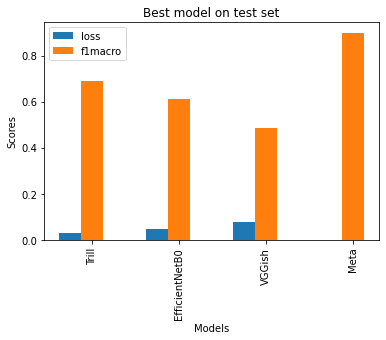

In [122]:
score = {}
loss = {}

score['Trill'] = 0.6876
score['EfficientNetB0'] = 0.6120
score['VGGish'] = 0.4858
score['Meta'] = 0.8984

loss['Trill'] = 0.0290
loss['EfficientNetB0'] = 0.0492
loss['VGGish'] = 0.0762
loss['Meta'] = 0

ind = np.arange(4)
width = 0.25
plt.bar(ind, loss.values(), width, label='loss')
plt.bar(ind + width, score.values(), width, label='f1macro')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Best model on test set')

plt.xticks(ind + width, ['Trill', 'EfficientNetB0', 'VGGish', 'Meta'], rotation=90)
plt.legend(loc='best')
plt.show()